In [2]:
from functools import partial

import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots

from statsmodels.api import OLS

import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.exceptions import ConvergenceWarning

from ISLP import load_data
from ISLP.models import ModelSpec as MS
from ISLP.models import (Stepwise, sklearn_selected, sklearn_selection_path)

from l0bnb import fit_path

import warnings

# Supress all warnings (when using l2_norm = 0)
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn')
warnings.filterwarnings("ignore", category=ConvergenceWarning)

## Subset selection methods

### Forward selection

In [3]:
Hitters = load_data('Hitters')
Hitters

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,497,127,7,65,48,37,5,2703,806,32,379,311,138,N,E,325,9,3,700.0,N
318,492,136,5,76,50,94,12,5511,1511,39,897,451,875,A,E,313,381,20,875.0,A
319,475,126,3,61,43,52,6,1700,433,7,217,93,146,A,W,37,113,7,385.0,A
320,573,144,9,85,60,78,8,3198,857,97,470,420,332,A,E,1314,131,12,960.0,A


In [4]:
np.isnan(Hitters['Salary']).sum()

59

In [5]:
Hitters = Hitters.dropna()
Hitters.shape

(263, 20)

In [6]:
ms = MS(Hitters.columns.drop('Salary')).fit(Hitters)
y = np.array(Hitters['Salary'])
X = ms.transform(Hitters)
sigma2 = OLS(y, X).fit().scale
sigma2

99591.35617968222

In [7]:
def nCp(sigma2, estimator, X, y):
    "Negative Cp statistic"

    n, p = X.shape
    yhat = estimator.predict(X)
    RSS = np.sum((y - yhat) ** 2)
    return -(RSS + 2 * p * sigma2) / n

In [8]:
neg_Cp = partial(nCp, sigma2)
neg_Cp

functools.partial(<function nCp at 0x303ebc0e0>, 99591.35617968222)

In [9]:
strategy = Stepwise.first_peak(ms, direction='forward', max_terms=len(ms.terms))
strategy

Strategy(initial_state=(), candidate_states=<bound method Stepwise.candidate_states of <ISLP.models.strategy.Stepwise object at 0x303eb2030>>, build_submodel=<bound method ModelSpec.build_submodel of ModelSpec(terms=Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat',
       'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'League', 'Division',
       'PutOuts', 'Assists', 'Errors', 'NewLeague'],
      dtype='object'))>, check_finished=<function first_peak at 0x302c9f060>, postprocess=<function _postprocess_best at 0x302c9f2e0>)

In [10]:
hitters_MSE = sklearn_selected(OLS, strategy)
hitters_MSE.fit(Hitters, y)
hitters_MSE.selected_state_

('Assists',
 'AtBat',
 'CAtBat',
 'CHits',
 'CHmRun',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Errors',
 'Hits',
 'HmRun',
 'League',
 'NewLeague',
 'PutOuts',
 'RBI',
 'Runs',
 'Walks',
 'Years')

In [11]:
hitters_Cp = sklearn_selected(OLS, strategy, scoring=neg_Cp)
hitters_Cp.fit(Hitters, y)
hitters_Cp.selected_state_

('Assists',
 'AtBat',
 'CAtBat',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Hits',
 'PutOuts',
 'Walks')

### Choosing among models using the validation set approach and cross-validation

In [11]:
strategy = Stepwise.fixed_steps(ms, len(ms.terms), direction='forward')
full_path = sklearn_selection_path(OLS, strategy)
full_path

,model_type,<class 'stats...ar_model.OLS'>
,strategy,"Strategy(init...289bba0>, 19))"
,model_args,{}
,scoring,None
,cv,None


In [12]:
full_path.fit(Hitters, y)
yhat_in = full_path.predict(Hitters)
yhat_in.shape

(263, 20)

(50000.0, 250000.0)

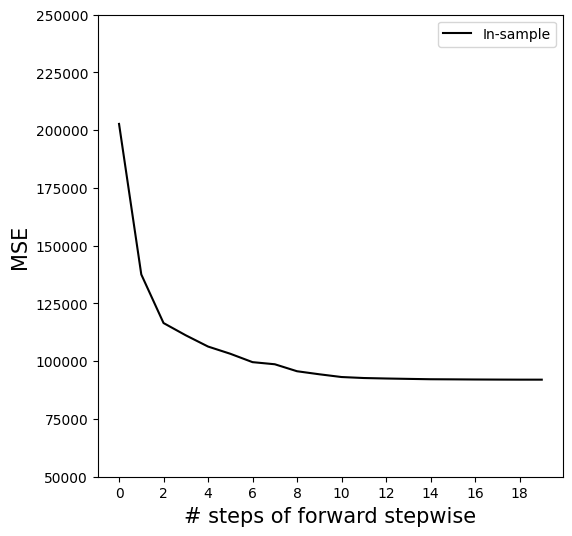

In [13]:
mse_fig, ax = subplots(figsize=(6, 6))
insample_mse = ((yhat_in - y[:, None])**2).mean(0)
n_steps = insample_mse.shape[0]
ax.plot(np.arange(n_steps), insample_mse, 'k', label='In-sample')
ax.set_ylabel('MSE', fontsize=15)
ax.set_xlabel('# steps of forward stepwise', fontsize=15)
ax.set_xticks(np.arange(n_steps)[::2])
ax.legend()
ax.set_ylim([50_000, 250_000])

In [14]:
k = 5

kfold = skm.KFold(k, random_state=0, shuffle=True)
yhat_cv = skm.cross_val_predict(full_path, Hitters, y, cv=kfold)
yhat_cv.shape

(263, 20)

In [15]:
cv_mse = []

for train_idx, test_idx in kfold.split(y):
    errors = (yhat_cv[test_idx] - y[test_idx, None])**2
    # column mean
    cv_mse.append(errors.mean(0))

cv_mse = np.array(cv_mse).T
cv_mse.shape

(20, 5)

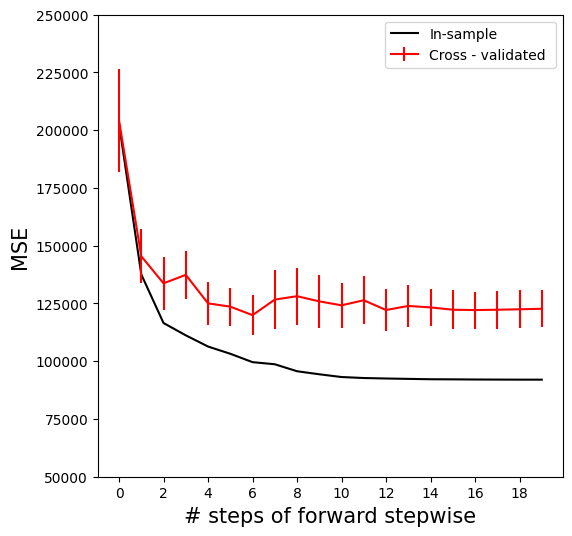

In [16]:
ax.errorbar(
    np.arange(n_steps), 
    cv_mse.mean(1),
    cv_mse.std(1) / np.sqrt(k),
    label='Cross - validated ',
    c='r'
)
ax.set_ylim([50_000 ,250_000])
ax.legend()
mse_fig

In [17]:
y[:4, None]

array([[475. ],
       [480. ],
       [500. ],
       [ 91.5]])

In [18]:
validation = skm.ShuffleSplit(n_splits=1, test_size=.2, random_state=0)

for train_idx, test_idx in validation.split(y):
    full_path.fit(Hitters.iloc[train_idx], y[train_idx])
    yhat_val = full_path.predict(Hitters.iloc[test_idx])
    errors = (yhat_val - y[test_idx, None])**2
    validation_mse = errors.mean(0)

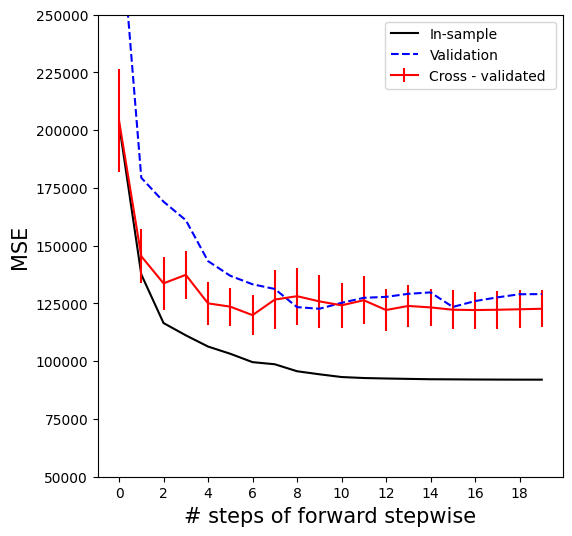

In [19]:
ax.plot(np.arange(n_steps), validation_mse, 'b--', label='Validation')
ax.set_xticks(np.arange(n_steps)[::2])
ax.set_ylim([50_000, 250_000])
ax.legend()
mse_fig

### Best subset selection

In [20]:
D = ms.fit_transform(Hitters)
D = D.drop('intercept', axis=1)
X = np.asarray(D)
X

array([[315.,  81.,   7., ...,  43.,  10.,   1.],
       [479., 130.,  18., ...,  82.,  14.,   0.],
       [496., 141.,  20., ...,  11.,   3.,   1.],
       ...,
       [475., 126.,   3., ..., 113.,   7.,   0.],
       [573., 144.,   9., ..., 131.,  12.,   0.],
       [631., 170.,   9., ...,   4.,   3.,   0.]])

In [21]:
path = fit_path(X, y, max_nonzeros=X.shape[1])

Preprocessing Data.
BnB Started.
Iteration: 1. Number of non-zeros:  1
Iteration: 2. Number of non-zeros:  2
Iteration: 3. Number of non-zeros:  2
Iteration: 4. Number of non-zeros:  2
Iteration: 5. Number of non-zeros:  3
Iteration: 6. Number of non-zeros:  3
Iteration: 7. Number of non-zeros:  4
Iteration: 8. Number of non-zeros:  9
Iteration: 9. Number of non-zeros:  9
Iteration: 10. Number of non-zeros:  9
Iteration: 11. Number of non-zeros:  9
Iteration: 12. Number of non-zeros:  9
Iteration: 13. Number of non-zeros:  9
Iteration: 14. Number of non-zeros:  9
Iteration: 15. Number of non-zeros:  9
Iteration: 16. Number of non-zeros:  9
Iteration: 17. Number of non-zeros:  9
Iteration: 18. Number of non-zeros:  17
Iteration: 19. Number of non-zeros:  19


In [22]:
# 4th step
path[3]

{'B': array([0.        , 3.25484367, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.67775265, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ]),
 'B0': -38.98216739555551,
 'lambda_0': 0.011416248027450178,
 'M': 0.5829861733382012,
 'Time_exceeded': False}

## Ridge regression and the Lasso

### Ridge regression

In [23]:
X.mean(0)

array([4.03642586e+02, 1.07828897e+02, 1.16197719e+01, 5.47452471e+01,
       5.14866920e+01, 4.11140684e+01, 7.31178707e+00, 2.65754373e+03,
       7.22186312e+02, 6.92395437e+01, 3.61220532e+02, 3.30418251e+02,
       2.60266160e+02, 4.71482890e-01, 5.09505703e-01, 2.90711027e+02,
       1.18760456e+02, 8.59315589e+00, 4.63878327e-01])

In [24]:
# https://numpy.org/doc/2.2/reference/constants.html#numpy.newaxis
X.mean(0)[np.newaxis,:]

array([[4.03642586e+02, 1.07828897e+02, 1.16197719e+01, 5.47452471e+01,
        5.14866920e+01, 4.11140684e+01, 7.31178707e+00, 2.65754373e+03,
        7.22186312e+02, 6.92395437e+01, 3.61220532e+02, 3.30418251e+02,
        2.60266160e+02, 4.71482890e-01, 5.09505703e-01, 2.90711027e+02,
        1.18760456e+02, 8.59315589e+00, 4.63878327e-01]])

In [25]:
X.std(0)

array([1.47026890e+02, 4.50394546e+01, 8.74044338e+00, 2.54912146e+01,
       2.58334607e+01, 2.16767277e+01, 4.78449391e+00, 2.28223167e+03,
       6.46966151e+02, 8.20411635e+01, 3.30568316e+02, 3.22752315e+02,
       2.63553383e+02, 4.99186112e-01, 4.99909633e-01, 2.79401874e+02,
       1.44804495e+02, 6.59400225e+00, 4.98693518e-01])

In [26]:
y.shape

(263,)

In [27]:
10**np.linspace(8, -2, 100)

array([1.00000000e+08, 7.92482898e+07, 6.28029144e+07, 4.97702356e+07,
       3.94420606e+07, 3.12571585e+07, 2.47707636e+07, 1.96304065e+07,
       1.55567614e+07, 1.23284674e+07, 9.77009957e+06, 7.74263683e+06,
       6.13590727e+06, 4.86260158e+06, 3.85352859e+06, 3.05385551e+06,
       2.42012826e+06, 1.91791026e+06, 1.51991108e+06, 1.20450354e+06,
       9.54548457e+05, 7.56463328e+05, 5.99484250e+05, 4.75081016e+05,
       3.76493581e+05, 2.98364724e+05, 2.36448941e+05, 1.87381742e+05,
       1.48496826e+05, 1.17681195e+05, 9.32603347e+04, 7.39072203e+04,
       5.85702082e+04, 4.64158883e+04, 3.67837977e+04, 2.91505306e+04,
       2.31012970e+04, 1.83073828e+04, 1.45082878e+04, 1.14975700e+04,
       9.11162756e+03, 7.22080902e+03, 5.72236766e+03, 4.53487851e+03,
       3.59381366e+03, 2.84803587e+03, 2.25701972e+03, 1.78864953e+03,
       1.41747416e+03, 1.12332403e+03, 8.90215085e+02, 7.05480231e+02,
       5.59081018e+02, 4.43062146e+02, 3.51119173e+02, 2.78255940e+02,
      

$\lambda = 10^8$ to $\lambda = 10^{-2}$

In [28]:
# convergence warning are normal as per ISLP
Xs = X - X.mean(0)[np.newaxis,:]
X_scale = X.std(0)
Xs = Xs / X_scale[np.newaxis,:]
n_lambdas = 100
lambdas = 10**np.linspace(8, -2, n_lambdas) / y.std()
soln_array = skl.ElasticNet.path(Xs, y, l1_ratio=0, alphas=lambdas)[1]

In [29]:
soln_array.shape

(19, 100)

In [30]:
D.columns

Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat',
       'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'League[N]',
       'Division[W]', 'PutOuts', 'Assists', 'Errors', 'NewLeague[N]'],
      dtype='object')

In [31]:
soln_array.T

array([[ 8.00310363e-04,  8.89318672e-04,  6.95410715e-04, ...,
         5.15666738e-05, -1.09496252e-05, -5.74274914e-06],
       [ 1.00986867e-03,  1.12218451e-03,  8.77500619e-04, ...,
         6.50694021e-05, -1.38170424e-05, -7.24531429e-06],
       [ 1.27429625e-03,  1.41602291e-03,  1.10726717e-03, ...,
         8.21076995e-05, -1.74354208e-05, -9.14061794e-06],
       ...,
       [-2.90923382e+02,  3.37260446e+02,  3.75180641e+01, ...,
         5.36633570e+01, -2.21910710e+01, -1.23832054e+01],
       [-2.90958537e+02,  3.37377455e+02,  3.75871222e+01, ...,
         5.36777586e+01, -2.21848930e+01, -1.23761905e+01],
       [-2.90986528e+02,  3.37470648e+02,  3.76420770e+01, ...,
         5.36891521e+01, -2.21799639e+01, -1.23705867e+01]])

In [32]:
soln_path = pd.DataFrame(soln_array.T, columns=D.columns, index=-np.log(lambdas))
soln_path.index.name = 'negative log(lambda)'
soln_path

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League[N],Division[W],PutOuts,Assists,Errors,NewLeague[N]
negative log(lambda),,,,,,,,,,,,,,,,,,,
-12.310855,0.000800,0.000889,0.000695,0.000851,0.000911,0.000900,0.000812,0.001067,0.001113,0.001064,0.001141,0.001149,0.000993,-0.000029,-0.000390,0.000609,0.000052,-0.000011,-0.000006
-12.078271,0.001010,0.001122,0.000878,0.001074,0.001150,0.001135,0.001025,0.001346,0.001404,0.001343,0.001439,0.001450,0.001253,-0.000037,-0.000492,0.000769,0.000065,-0.000014,-0.000007
-11.845686,0.001274,0.001416,0.001107,0.001355,0.001451,0.001433,0.001293,0.001698,0.001772,0.001694,0.001816,0.001830,0.001581,-0.000046,-0.000621,0.000970,0.000082,-0.000017,-0.000009
-11.613102,0.001608,0.001787,0.001397,0.001710,0.001831,0.001808,0.001632,0.002143,0.002236,0.002138,0.002292,0.002309,0.001995,-0.000058,-0.000784,0.001224,0.000104,-0.000022,-0.000012
-11.380518,0.002029,0.002255,0.001763,0.002158,0.002310,0.002281,0.002059,0.002704,0.002821,0.002698,0.002892,0.002914,0.002517,-0.000073,-0.000990,0.001544,0.000131,-0.000028,-0.000015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.784658,-290.823989,336.929968,37.322686,-59.748520,-26.507086,134.855915,-17.216195,-387.775826,89.573601,-12.273926,476.079273,257.271255,-213.124780,31.258215,-58.457857,78.761266,53.622113,-22.208456,-12.402891
10.017243,-290.879272,337.113713,37.431373,-59.916820,-26.606957,134.900549,-17.108041,-388.458404,89.000707,-12.661459,477.031349,257.966790,-213.280891,31.256434,-58.448850,78.761240,53.645147,-22.198802,-12.391969
10.249827,-290.923382,337.260446,37.518064,-60.051166,-26.686604,134.936136,-17.022194,-388.997470,88.537380,-12.971603,477.791860,258.523025,-213.405740,31.254958,-58.441682,78.761230,53.663357,-22.191071,-12.383205


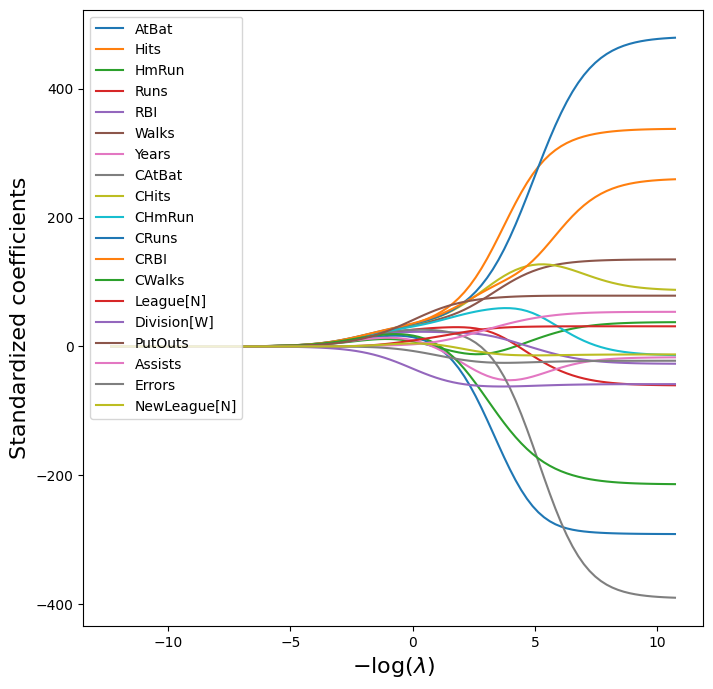

In [33]:
path_fig, ax = subplots(figsize=(8, 8))
soln_path.plot(ax=ax, legend=False)
ax.set_xlabel("$-\\log(\\lambda)$", fontsize=16)
ax.set_ylabel("Standardized coefficients", fontsize=16)
ax.legend(loc="upper left");

In [34]:
beta_hat = soln_path.loc[soln_path.index[39]]
lambdas[39], beta_hat

(25.53538897200662,
 AtBat           5.433750
 Hits            6.223582
 HmRun           4.585498
 Runs            5.880855
 RBI             6.195921
 Walks           6.277975
 Years           5.299767
 CAtBat          7.147501
 CHits           7.539495
 CHmRun          7.182344
 CRuns           7.728649
 CRBI            7.790702
 CWalks          6.592901
 League[N]       0.042445
 Division[W]    -3.107159
 PutOuts         4.605263
 Assists         0.378371
 Errors         -0.135196
 NewLeague[N]    0.150323
 Name: -3.240065292879872, dtype: float64)

In [35]:
np.linalg.norm(beta_hat)

24.17061720144378

In [36]:
beta_hat = soln_path.loc[soln_path.index[59]]
lambdas[59], beta_hat

(0.24374766133488554,
 AtBat          -13.413403
 Hits            59.910519
 HmRun           -5.295713
 Runs            29.658417
 RBI             22.029391
 Walks           46.246392
 Years          -11.475182
 CAtBat          22.718492
 CHits           51.622336
 CHmRun          43.254987
 CRuns           52.365074
 CRBI            54.560412
 CWalks          -8.126305
 League[N]       17.742989
 Division[W]    -53.458076
 PutOuts         62.500680
 Assists         10.394737
 Errors         -16.702281
 NewLeague[N]     0.557879
 Name: 1.4116217636737547, dtype: float64)

In [37]:
np.linalg.norm(beta_hat)

160.42371017725839

Using `Pipeline` object tto separate feature normalization from fitting the model.

In [38]:
ridge = skl.ElasticNet(alpha=lambdas[59], l1_ratio=0)
scaler = StandardScaler(with_mean=True, with_std=True)
pipe = Pipeline(steps=[('scaler', scaler), ('ridge', ridge)])
pipe.fit(X, y)

,steps,"[('scaler', ...), ('ridge', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,alpha,0.24374766133488554
,l1_ratio,0
,fit_intercept,True
,precompute,False


In [39]:
ridge.coef_

array([-13.41340311,  59.91051939,  -5.29571294,  29.6584166 ,
        22.02939114,  46.24639176, -11.47518234,  22.71849222,
        51.62233576,  43.25498655,  52.36507445,  54.56041213,
        -8.12630545,  17.74298859, -53.45807592,  62.50067954,
        10.39473746, -16.70228091,   0.55787883])

In [40]:
np.linalg.norm(ridge.coef_)

160.4237101772591

#### Estimating test error of ridge regression

Using $\alpha = .01$

In [41]:
validation = skm.ShuffleSplit(n_splits=1, test_size=.5, random_state=0)
ridge.alpha = .01
results = skm.cross_validate(ridge, X, y, scoring='neg_mean_squared_error', cv=validation)
-results['test_score']

array([134214.00419204])

Using $\alpha = 10^{10}$

In [42]:
ridge.alpha = 1e10
results = skm.cross_validate(ridge, X, y, scoring='neg_mean_squared_error', cv=validation)
-results['test_score']

array([231788.32155285])

Using `GridSearchCV` to search for $\lambda$

In [43]:
param_grid = {'ridge__alpha': lambdas}
grid = skm.GridSearchCV(pipe, param_grid, cv=validation, scoring='neg_mean_squared_error')
grid.fit(X, y)

,estimator,Pipeline(step...l1_ratio=0))])
,param_grid,{'ridge__alpha': array([2.2209...22093791e-05])}
,scoring,'neg_mean_squared_error'
,n_jobs,None
,refit,True
,cv,ShuffleSplit(...ain_size=None)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [44]:
grid.best_params_['ridge__alpha'], grid.best_estimator_

(0.005899006046740856,
 Pipeline(steps=[('scaler', StandardScaler()),
                 ('ridge', ElasticNet(alpha=0.005899006046740856, l1_ratio=0))]))

With 5-fold cross-validation

In [45]:
grid = skm.GridSearchCV(pipe, param_grid, cv=kfold, scoring='neg_mean_squared_error')
grid.fit(X, y)

,estimator,Pipeline(step...l1_ratio=0))])
,param_grid,{'ridge__alpha': array([2.2209...22093791e-05])}
,scoring,'neg_mean_squared_error'
,n_jobs,None
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [46]:
grid.best_params_['ridge__alpha'], grid.best_estimator_

(0.01185247763144249,
 Pipeline(steps=[('scaler', StandardScaler()),
                 ('ridge', ElasticNet(alpha=0.01185247763144249, l1_ratio=0))]))

Plot of cross-validated MSE

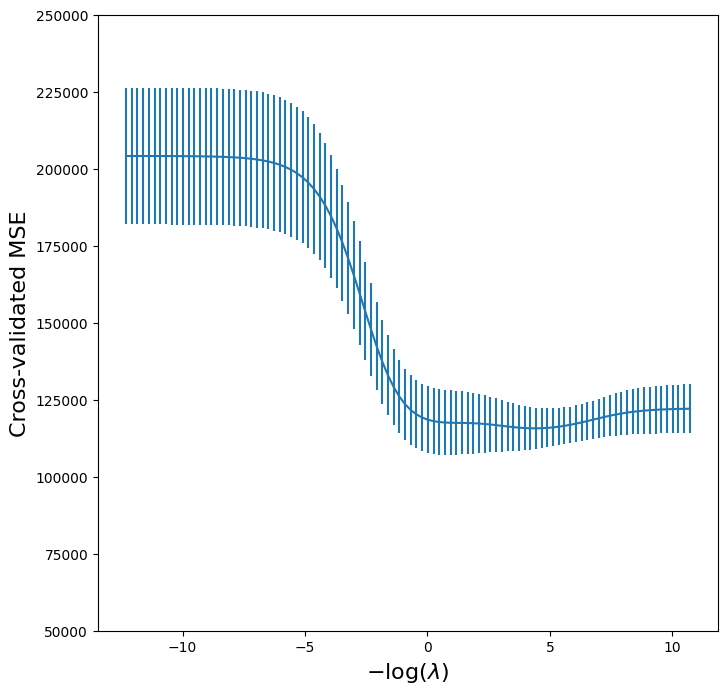

In [47]:
ridge_fig, ax = subplots(figsize=(8,8))
ax.errorbar(
    -np.log(lambdas), 
    -grid.cv_results_['mean_test_score'],
    yerr=grid.cv_results_['std_test_score'] / np.sqrt(k))
ax.set_ylim([50_000, 250_000])
ax.set_xlabel("$-\\log(\\lambda)$", fontsize=16)
ax.set_ylabel("Cross-validated MSE", fontsize=16);

Using `GridSearchCV` with $R^2$ scoring

In [48]:
grid_r2 = skm.GridSearchCV(pipe, param_grid, cv=kfold)
grid_r2.fit(X, y)

,estimator,Pipeline(step...l1_ratio=0))])
,param_grid,{'ridge__alpha': array([2.2209...22093791e-05])}
,scoring,None
,n_jobs,None
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


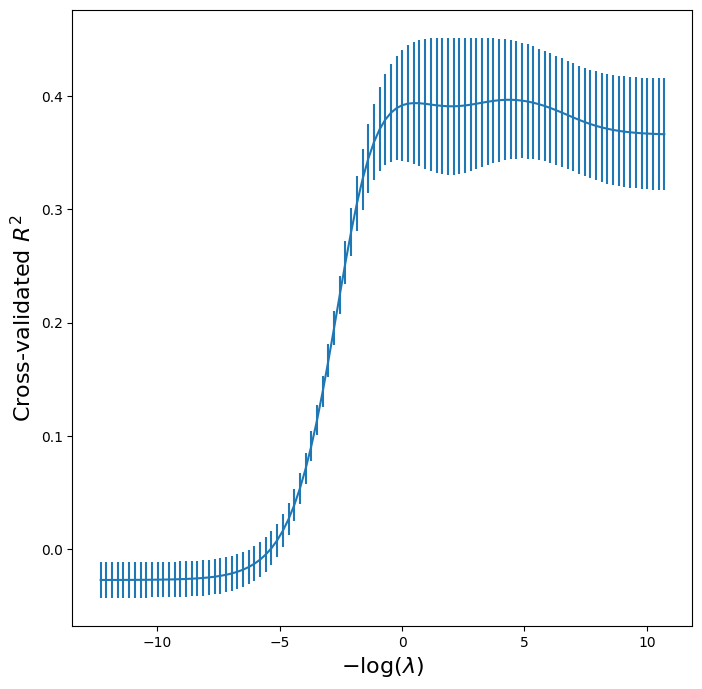

In [49]:
r2_fig, ax = subplots(figsize=(8,8))
ax.errorbar(
    -np.log(lambdas), 
    grid_r2.cv_results_['mean_test_score'],
    yerr=grid_r2.cv_results_['std_test_score'] / np.sqrt(k))
ax.set_xlabel("$-\\log(\\lambda)$", fontsize=16)
ax.set_ylabel("Cross-validated $R^2$", fontsize=16);

#### Fast cross-validation for solution paths

In [50]:
ridgeCV = skl.ElasticNetCV(alphas=lambdas, l1_ratio=0, cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler), ('ridge', ridgeCV)])
pipeCV.fit(X, y)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge',
                 ElasticNetCV(alphas=array([2.22093791e+05, 1.76005531e+05, 1.39481373e+05, 1.10536603e+05,
       8.75983676e+04, 6.94202082e+04, 5.50143278e+04, 4.35979140e+04,
       3.45506012e+04, 2.73807606e+04, 2.16987845e+04, 1.71959156e+04,
       1.36274691e+04, 1.07995362e+04, 8.55844774e+03, 6.78242347e+03,
       5.37495461e+03, 4.25955961e+03,...
       1.84386167e-03, 1.46122884e-03, 1.15799887e-03, 9.17694298e-04,
       7.27257037e-04, 5.76338765e-04, 4.56738615e-04, 3.61957541e-04,
       2.86845161e-04, 2.27319885e-04, 1.80147121e-04, 1.42763513e-04,
       1.13137642e-04, 8.96596467e-05, 7.10537367e-05, 5.63088712e-05,
       4.46238174e-05, 3.53636122e-05, 2.80250579e-05, 2.22093791e-05]),
                              cv=KFold(n_splits=5, random_state=0, shuffle=True),
                              l1_ratio=0))])

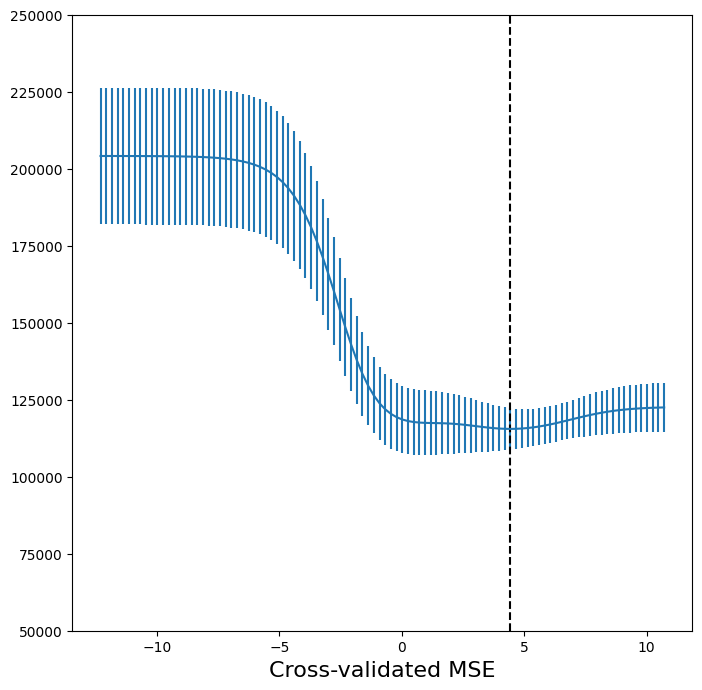

In [51]:
tuned_ridge = pipeCV.named_steps['ridge']
ridgeCV_fig, ax = subplots(figsize=(8, 8))
ax.errorbar(
    -np.log(lambdas), 
    tuned_ridge.mse_path_.mean(1),
    yerr=tuned_ridge.mse_path_.std(1) / np.sqrt(k)
)
ax.axvline(-np.log(tuned_ridge.alpha_), c='k', ls='--')
ax.set_ylim([50_000, 250_000])
ax.set_xlabel("-\\log(\\lambda)$", fontsize=16)
ax.set_xlabel("Cross-validated MSE", fontsize=16);

In [52]:
np.min(tuned_ridge.mse_path_.mean(1))

115526.70630987917

In [53]:
tuned_ridge.coef_

array([-222.80877051,  238.77246614,    3.21103754,   -2.93050845,
          3.64888723,  108.90953869,  -50.81896152, -105.15731984,
        122.00714801,   57.1859509 ,  210.35170348,  118.05683748,
       -150.21959435,   30.36634231,  -61.62459095,   77.73832472,
         40.07350744,  -25.02151514,  -13.68429544])

#### Evaluating test error of cross-validated ridge

In [54]:
outer_valid = skm.ShuffleSplit(n_splits=1, test_size=.25, random_state=1)
inner_cv = skm.KFold(n_splits=5, shuffle=True, random_state=2)
ridgeCV = skl.ElasticNetCV(alphas=lambdas, l1_ratio=0, cv=inner_cv)
pipeCV = Pipeline(steps=[('scaler', scaler), ('ridge', ridgeCV)])

In [55]:
results = skm.cross_validate(pipeCV, X, y, cv=outer_valid, scoring='neg_mean_squared_error')
-results['test_score']

array([132393.84003227])

### Lasso

In [56]:
lassoCV = skl.ElasticNetCV(alphas=100, l1_ratio=1, cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler), ('lasso', lassoCV)])
pipeCV.fit(X, y)

,steps,"[('scaler', ...), ('lasso', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,l1_ratio,1
,eps,0.001
,n_alphas,'deprecated'
,alphas,100


In [57]:
tuned_lasso = pipeCV.named_steps['lasso']
tuned_lasso.alpha_

3.1472370031649866

In [58]:
skl.Lasso.path(Xs, y, l1_ratio=1, n_alphas=100)[:2]

(array([255.28209651, 238.0769376 , 222.03134882, 207.06717903,
        193.11154419, 180.09647243, 167.95857295, 156.63872727,
        146.08180131, 136.23637682, 127.05450099, 118.49145286,
        110.50552551, 103.05782294,  96.1120706 ,  89.63443871,
         83.59337754,  77.95946367,  72.70525674,  67.80516577,
         63.23532454,  58.9734753 ,  54.99886045,  51.29212133,
         47.83520402,  44.61127137,  41.60462098,  38.80060878,
         36.18557761,  33.74679078,  31.47237003,  29.35123763,
         27.37306245,  25.52820965,  23.80769376,  22.20313488,
         20.7067179 ,  19.31115442,  18.00964724,  16.7958573 ,
         15.66387273,  14.60818013,  13.62363768,  12.7054501 ,
         11.84914529,  11.05055255,  10.30578229,   9.61120706,
          8.96344387,   8.35933775,   7.79594637,   7.27052567,
          6.78051658,   6.32353245,   5.89734753,   5.49988604,
          5.12921213,   4.7835204 ,   4.46112714,   4.1604621 ,
          3.88006088,   3.61855776,   3.

In [59]:
lambdas, soln_array = skl.Lasso.path(Xs, y, l1_ratio=1, n_alphas=100)[:2]
soln_path = pd.DataFrame(soln_array.T, columns=D.columns, index=-np.log(lambdas))

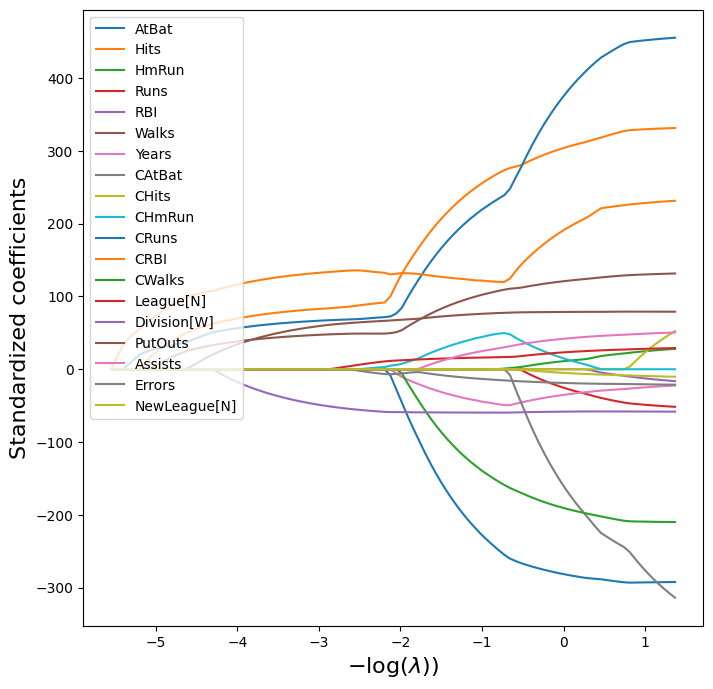

In [60]:
path_fig, ax = subplots(figsize=(8, 8))
soln_path.plot(ax=ax, legend=False)
ax.legend(loc='upper left')
ax.set_xlabel("$-\\log(\\lambda))$", fontsize=16)
ax.set_ylabel("Standardized coefficients", fontsize=16);

In [61]:
np.min(tuned_lasso.mse_path_.mean(1))

114690.73118253727

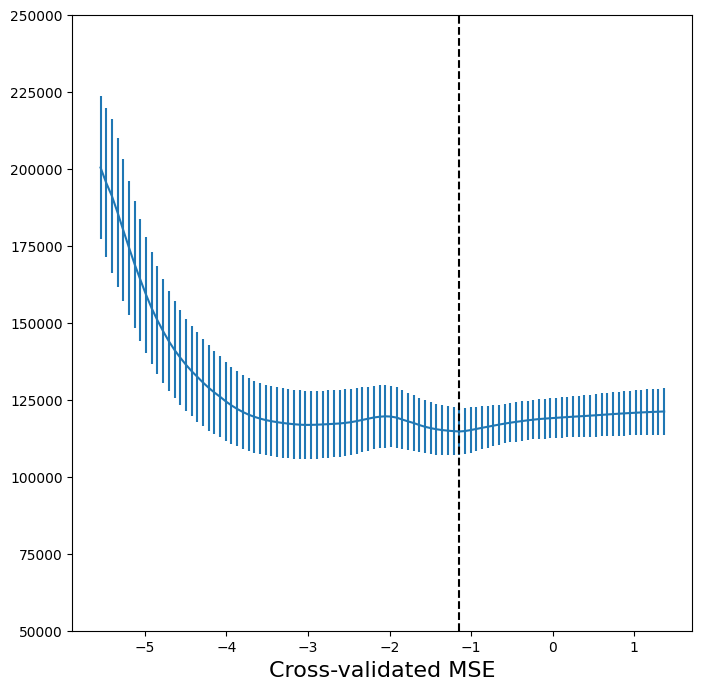

In [62]:
lassoCV_fig, ax = subplots(figsize=(8, 8))
ax.errorbar(
    -np.log(tuned_lasso.alphas_),
    tuned_lasso.mse_path_.mean(1),
    yerr=tuned_lasso.mse_path_.std(1) / np.sqrt(k)
)
ax.axvline(-np.log(tuned_lasso.alpha_), c='k', ls='--')
ax.set_ylim([50_000, 250_000])
ax.set_xlabel("-\\log(\\lambda)$", fontsize=16)
ax.set_xlabel("Cross-validated MSE", fontsize=16);

6 of the 19 coefficient esitmates are exactly zero.

In [63]:
tuned_lasso.coef_

array([-210.01008773,  243.4550306 ,    0.        ,    0.        ,
          0.        ,   97.69397357,  -41.52283116,   -0.        ,
          0.        ,   39.62298193,  205.75273856,  124.55456561,
       -126.29986768,   15.70262427,  -59.50157967,   75.24590036,
         21.62698014,  -12.04423675,   -0.        ])

Todo:
- evaluate test error of cross-validated lasso

## PCR and PLS regression

### Principal component regression

In [64]:
pca = PCA(n_components=2)
linreg = skl.LinearRegression()
pipe = Pipeline([('pca', pca), ('linreg', linreg)])
pipe.fit(X, y)

,steps,"[('pca', ...), ('linreg', ...)]"
,transform_input,None
,memory,None
,verbose,False
,n_components,2
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10


In [65]:
pipe.named_steps['linreg'].coef_

array([0.09846131, 0.4758765 ])

Adding scaler to the pipeline.

In [66]:
pipe = Pipeline([('scaler', scaler), ('pca', pca), ('linreg', linreg)])
pipe.fit(X, y)

,steps,"[('scaler', ...), ('pca', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_components,2
,copy,True
,whiten,False
,svd_solver,'auto'


In [67]:
pipe.named_steps['linreg'].coef_

array([106.36859204,  21.60350456])

In [68]:
parameters = {
    'pca__n_components': range(1, 20)
}
grid = skm.GridSearchCV(pipe, parameters, cv=kfold, scoring='neg_mean_squared_error')
grid.fit(X, y)

,estimator,Pipeline(step...egression())])
,param_grid,"{'pca__n_components': range(1, 20)}"
,scoring,'neg_mean_squared_error'
,n_jobs,None
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [1]:
_, ax = subplots(figsize=(8, 8))
n_comp = parameters['pca__n_components']
ax.errorbar(
    n_comp, 
    -grid.cv_results_['mean_test_score'],
    grid.cv_results_['std_test_score'] / np.sqrt(k)
)
ax.set_ylabel('Cross-validated MSE')
ax.set_xlabel('# principal components')
ax.set_xticks(n_comp[::2])
ax.set_ylim([50_000, 250_000]);

NameError: name 'subplots' is not defined

MSE for null model.

In [70]:
Xn = np.zeros((X.shape[0], 1))
cv_null = skm.cross_validate(
    linreg,
    Xn,
    y,
    cv=kfold,
    scoring='neg_mean_squared_error'
)
-cv_null['test_score'].mean()

204139.30692994667

In [71]:
pipe.named_steps['pca'].explained_variance_ratio_

array([0.3831424 , 0.21841076])

### Partial least squares

In [72]:
pls = PLSRegression(n_components=2, scale=True)
pls.fit(X, y)

,n_components,2
,scale,True
,max_iter,500
,tol,1e-06
,copy,True


In [73]:
parameters = {
    'n_components': range(1, 20)
}
grid = skm.GridSearchCV(pls, parameters, cv=kfold, scoring='neg_mean_squared_error')
grid.fit(X, y)

,estimator,PLSRegression()
,param_grid,"{'n_components': range(1, 20)}"
,scoring,'neg_mean_squared_error'
,n_jobs,None
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_components,12


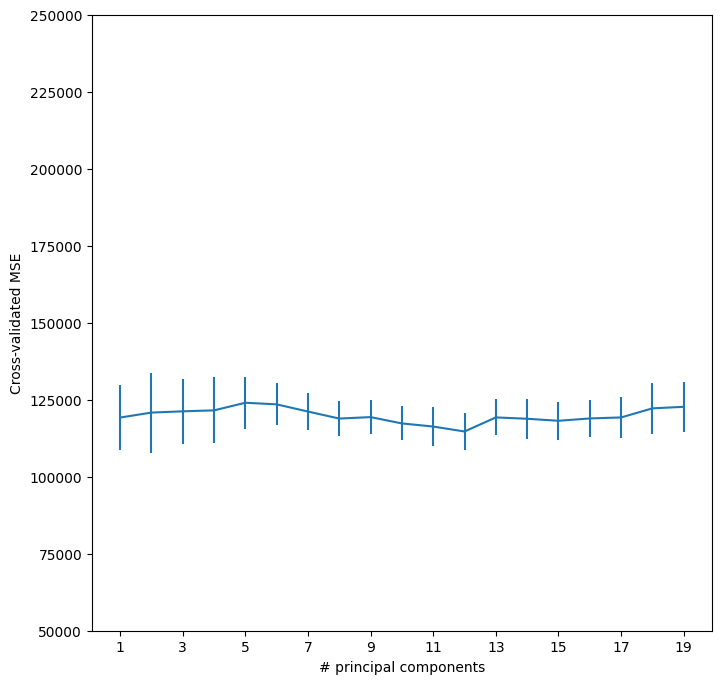

In [74]:
_, ax = subplots(figsize=(8, 8))
n_comp = parameters['n_components']
ax.errorbar(
    n_comp, 
    -grid.cv_results_['mean_test_score'],
    grid.cv_results_['std_test_score'] / np.sqrt(k)
)
ax.set_ylabel('Cross-validated MSE')
ax.set_xlabel('# principal components')
ax.set_xticks(n_comp[::2])
ax.set_ylim([50_000, 250_000]);